# Script to read MEOP data

In [1]:
processdir = '/home/jupyter-froqu/MEOP_process'
from os import walk
from os.path import isfile, join
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import gsw


/opt/tljh/user/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
def read_ncfile(depl,smru_name,qf):
    pathfile = join(processdir,'final_dataset_prof',depl,smru_name+'_'+qf+'_prof.nc')
    ds = xr.open_dataset(pathfile)
    for dim in ds.dims:
        ds[dim] = ((dim), ds[dim])
        ds.set_coords([dim])
    ds['N_TEMP'] = (('N_PROF'),np.sum((ds['TEMP_QC']==b'1'),axis=1))
    ds['N_PSAL'] = (('N_PSAL'),np.sum((ds['PSAL_QC']==b'1'),axis=1))
    ds['N_CHLA'] = (('N_PROF'),np.sum((ds['CHLA_QC']==b'1'),axis=1))
    return ds
    
depl = 'ct107'
smru_name = 'ct107-933-13'
qf = 'lr1'
ds = read_ncfile(depl,smru_name,qf)

In [3]:
ds

<xarray.Dataset>
Dimensions:                       (N_CALIB: 1, N_LEVELS: 16, N_PARAM: 4, N_PROF: 202, N_PSAL: 202)
Coordinates:
  * N_CALIB                       (N_CALIB) int64 0
  * N_LEVELS                      (N_LEVELS) int64 0 1 2 3 4 ... 11 12 13 14 15
  * N_PARAM                       (N_PARAM) int64 0 1 2 3
  * N_PROF                        (N_PROF) int64 0 1 2 3 4 ... 198 199 200 201
  * N_PSAL                        (N_PSAL) int64 16 16 16 16 8 ... 16 16 8 16 8
Data variables:
    DATA_TYPE                     object ...
    FORMAT_VERSION                object ...
    HANDBOOK_VERSION              object ...
    REFERENCE_DATE_TIME           object ...
    DATE_CREATION                 object ...
    DATE_UPDATE                   object ...
    PLATFORM_NUMBER               (N_PROF) object ...
    PROJECT_NAME                  (N_PROF) object ...
    PI_NAME                       (N_PROF) object ...
    STATION_PARAMETERS            (N_PROF, N_PARAM) object ...
    CYCLE_NUMBER                  (N_PROF) float64 ...
    DIRECTION                     (N_PROF) object ...
    DATA_CENTRE                   (N_PROF) object ...
    DC_REFERENCE                  (N_PROF) object ...
    DATA_STATE_INDICATOR          (N_PROF) object ...
    DATA_MODE                     (N_PROF) object ...
    INST_REFERENCE                (N_PROF) object ...
    WMO_INST_TYPE                 (N_PROF) object ...
    JULD                          (N_PROF) object ...
    JULD_QC                       (N_PROF) object ...
    JULD_LOCATION                 (N_PROF) object ...
    LATITUDE                      (N_PROF) float64 ...
    LONGITUDE                     (N_PROF) float64 ...
    POSITION_QC                   (N_PROF) object ...
    POSITIONING_SYSTEM            (N_PROF) object ...
    PROFILE_PRES_QC               (N_PROF) object ...
    PROFILE_PSAL_QC               (N_PROF) object ...
    PROFILE_TEMP_QC               (N_PROF) object ...
    PRES                          (N_PROF, N_LEVELS) float32 ...
    PRES_QC                       (N_PROF, N_LEVELS) object ...
    PRES_ADJUSTED                 (N_PROF, N_LEVELS) float32 ...
    PRES_ADJUSTED_QC              (N_PROF, N_LEVELS) object ...
    PRES_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 ...
    TEMP                          (N_PROF, N_LEVELS) float32 ...
    TEMP_QC                       (N_PROF, N_LEVELS) object b'1' b'1' ... b'9'
    TEMP_ADJUSTED                 (N_PROF, N_LEVELS) float32 ...
    TEMP_ADJUSTED_QC              (N_PROF, N_LEVELS) object ...
    TEMP_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 ...
    PSAL                          (N_PROF, N_LEVELS) float32 ...
    PSAL_QC                       (N_PROF, N_LEVELS) object b'1' b'1' ... b'9'
    PSAL_ADJUSTED                 (N_PROF, N_LEVELS) float32 ...
    PSAL_ADJUSTED_QC              (N_PROF, N_LEVELS) object ...
    PSAL_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 ...
    PROFILE_CHLA_QC               (N_PROF) object ...
    CHLA                          (N_PROF, N_LEVELS) float32 ...
    CHLA_QC                       (N_PROF, N_LEVELS) object b'9' b'9' ... b'9'
    CHLA_ADJUSTED                 (N_PROF, N_LEVELS) float32 ...
    CHLA_ADJUSTED_QC              (N_PROF, N_LEVELS) object ...
    CHLA_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 ...
    PARAMETER                     (N_PROF, N_CALIB, N_PARAM) object ...
    SCIENTIFIC_CALIB_EQUATION     (N_PROF, N_CALIB, N_PARAM) object ...
    SCIENTIFIC_CALIB_COEFFICIENT  (N_PROF, N_CALIB, N_PARAM) object ...
    N_TEMP                        (N_PROF) int64 16 16 16 16 8 ... 16 16 8 16 8
    N_CHLA                        (N_PROF) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
Attributes:
    comment:                   
    pi_name:                  COSTA
    data_type:                Marine mammals time-series data
    format_version:           1.1
    date_update:              2020-03-29T12:21:32Z
    version_database:         MEOP-CTD_20

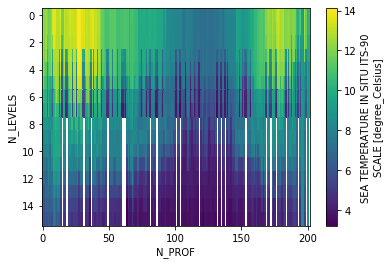

In [4]:
ds['TEMP'].T.plot(yincrease=False)

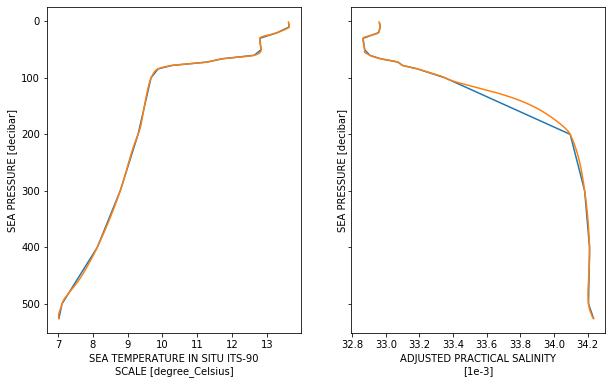

In [5]:
def create_var(ds,varname,nprof):
    var = xr.DataArray(ds[varname].isel(N_PROF=nprof), coords=[ds['PRES'].isel(N_PROF=nprof)], dims=['pres'])
    return var

# load interpolated data. Could be done more efficiently using the fact every profile is on the same vertical grid
ds_lr1 = read_ncfile(depl,smru_name,'lr1')

# load original data. Need to assign pressure separately for each profile.
ds_hr1 = read_ncfile(depl,smru_name,'hr1')

nprof = 10

fig, axes = plt.subplots(ncols=2, nrows=1, sharey = True, figsize=(10,6))
#create_var(ds_lr1,'TEMP',nprof).plot.line(y='pres', yincrease=False, ax=axes[0])
create_var(ds_lr1,'TEMP_ADJUSTED',nprof).plot.line(y='pres', yincrease=False, ax=axes[0])
#create_var(ds_lr1,'PSAL',nprof).plot.line(y='pres', yincrease=False, ax=axes[1])
create_var(ds_lr1,'PSAL_ADJUSTED',nprof).plot.line(y='pres', yincrease=False, ax=axes[1])
#create_var(ds_hr1,'TEMP',nprof).plot.line(y='pres', yincrease=False, ax=axes[0])
create_var(ds_hr1,'TEMP_ADJUSTED',nprof).plot.line(y='pres', yincrease=False, ax=axes[0])
#create_var(ds_hr1,'PSAL',nprof).plot.line(y='pres', yincrease=False, ax=axes[1])
create_var(ds_hr1,'PSAL_ADJUSTED',nprof).plot.line(y='pres', yincrease=False, ax=axes[1])


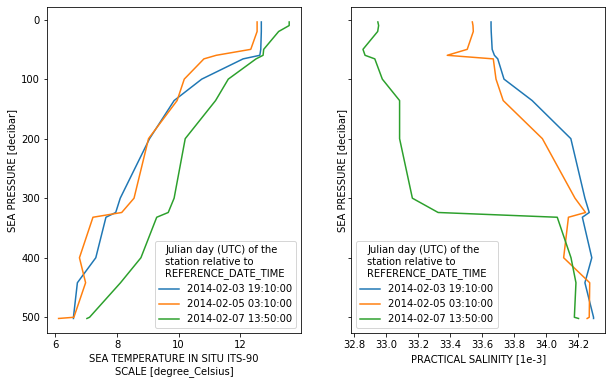

In [6]:
fig, axes = plt.subplots(ncols=2, nrows=1, sharey = True, figsize=(10,6))

TEMP = xr.DataArray(ds['TEMP'].T, coords=[ds['PRES'].isel(N_PROF=1),ds['JULD']], dims=['pres', 'time'])
TEMP.isel(time=[1,3,10]).plot.line(y='pres', hue='time', yincrease=False, ax=axes[0])

PSAL = xr.DataArray(ds['PSAL'].T, coords=[ds['PRES'].isel(N_PROF=1),ds['JULD']], dims=['pres', 'time'])
PSAL.isel(time=[1,3,10]).plot.line(y='pres', hue='time', yincrease=False, ax=axes[1])



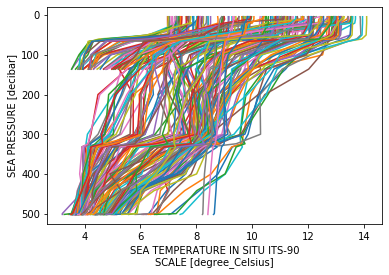

In [7]:
TEMP = xr.DataArray(ds['TEMP'].T, coords=[ds['PRES'].isel(N_PROF=1),ds['JULD']], dims=['pres', 'time'])
TEMP.plot.line(y='pres', hue='time', yincrease=False)
plt.gca().get_legend().remove()

In [8]:
ds2 = ds.copy()
ds2.reset_coords()

<xarray.Dataset>
Dimensions:                       (N_CALIB: 1, N_LEVELS: 16, N_PARAM: 4, N_PROF: 202, N_PSAL: 202)
Coordinates:
  * N_CALIB                       (N_CALIB) int64 0
  * N_LEVELS                      (N_LEVELS) int64 0 1 2 3 4 ... 11 12 13 14 15
  * N_PARAM                       (N_PARAM) int64 0 1 2 3
  * N_PROF                        (N_PROF) int64 0 1 2 3 4 ... 198 199 200 201
  * N_PSAL                        (N_PSAL) int64 16 16 16 16 8 ... 16 16 8 16 8
Data variables:
    DATA_TYPE                     object ...
    FORMAT_VERSION                object ...
    HANDBOOK_VERSION              object ...
    REFERENCE_DATE_TIME           object ...
    DATE_CREATION                 object ...
    DATE_UPDATE                   object ...
    PLATFORM_NUMBER               (N_PROF) object ...
    PROJECT_NAME                  (N_PROF) object ...
    PI_NAME                       (N_PROF) object ...
    STATION_PARAMETERS            (N_PROF, N_PARAM) object ...
    CYCLE_NUMBER                  (N_PROF) float64 ...
    DIRECTION                     (N_PROF) object ...
    DATA_CENTRE                   (N_PROF) object ...
    DC_REFERENCE                  (N_PROF) object ...
    DATA_STATE_INDICATOR          (N_PROF) object ...
    DATA_MODE                     (N_PROF) object ...
    INST_REFERENCE                (N_PROF) object ...
    WMO_INST_TYPE                 (N_PROF) object ...
    JULD                          (N_PROF) object ...
    JULD_QC                       (N_PROF) object ...
    JULD_LOCATION                 (N_PROF) object ...
    LATITUDE                      (N_PROF) float64 ...
    LONGITUDE                     (N_PROF) float64 ...
    POSITION_QC                   (N_PROF) object ...
    POSITIONING_SYSTEM            (N_PROF) object ...
    PROFILE_PRES_QC               (N_PROF) object ...
    PROFILE_PSAL_QC               (N_PROF) object ...
    PROFILE_TEMP_QC               (N_PROF) object ...
    PRES                          (N_PROF, N_LEVELS) float32 ...
    PRES_QC                       (N_PROF, N_LEVELS) object ...
    PRES_ADJUSTED                 (N_PROF, N_LEVELS) float32 ...
    PRES_ADJUSTED_QC              (N_PROF, N_LEVELS) object ...
    PRES_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 ...
    TEMP                          (N_PROF, N_LEVELS) float32 ...
    TEMP_QC                       (N_PROF, N_LEVELS) object b'1' b'1' ... b'9'
    TEMP_ADJUSTED                 (N_PROF, N_LEVELS) float32 ...
    TEMP_ADJUSTED_QC              (N_PROF, N_LEVELS) object ...
    TEMP_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 ...
    PSAL                          (N_PROF, N_LEVELS) float32 ...
    PSAL_QC                       (N_PROF, N_LEVELS) object b'1' b'1' ... b'9'
    PSAL_ADJUSTED                 (N_PROF, N_LEVELS) float32 ...
    PSAL_ADJUSTED_QC              (N_PROF, N_LEVELS) object ...
    PSAL_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 ...
    PROFILE_CHLA_QC               (N_PROF) object ...
    CHLA                          (N_PROF, N_LEVELS) float32 ...
    CHLA_QC                       (N_PROF, N_LEVELS) object b'9' b'9' ... b'9'
    CHLA_ADJUSTED                 (N_PROF, N_LEVELS) float32 ...
    CHLA_ADJUSTED_QC              (N_PROF, N_LEVELS) object ...
    CHLA_ADJUSTED_ERROR           (N_PROF, N_LEVELS) float32 ...
    PARAMETER                     (N_PROF, N_CALIB, N_PARAM) object ...
    SCIENTIFIC_CALIB_EQUATION     (N_PROF, N_CALIB, N_PARAM) object ...
    SCIENTIFIC_CALIB_COEFFICIENT  (N_PROF, N_CALIB, N_PARAM) object ...
    N_TEMP                        (N_PROF) int64 16 16 16 16 8 ... 16 16 8 16 8
    N_CHLA                        (N_PROF) int64 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
Attributes:
    comment:                   
    pi_name:                  COSTA
    data_type:                Marine mammals time-series data
    format_version:           1.1
    date_update:              2020-03-29T12:21:32Z
    version_database:         MEOP-CTD_20